In [1]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


# Libraries

In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System Libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2

# Extra


In [3]:
import warnings
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"godserenas","key":"34794ef6f323077dc3f8be830cb172f4"}'}

In [4]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Data

### Download the Data

In [7]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species
!unzip butterfly-images40-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/MILBERTS TORTOISESHELL/090.jpg  
  inflating: train/MILBERTS TORTOISESHELL/091.jpg  
  inflating: train/MILBERTS TORTOISESHELL/092.jpg  
  inflating: train/MILBERTS TORTOISESHELL/093.jpg  
  inflating: train/MILBERTS TORTOISESHELL/094.jpg  
  inflating: train/MILBERTS TORTOISESHELL/095.jpg  
  inflating: train/MILBERTS TORTOISESHELL/096.jpg  
  inflating: train/MILBERTS TORTOISESHELL/097.jpg  
  inflating: train/MILBERTS TORTOISESHELL/098.jpg  
  inflating: train/MILBERTS TORTOISESHELL/099.jpg  
  inflating: train/MILBERTS TORTOISESHELL/100.jpg  
  inflating: train/MILBERTS TORTOISESHELL/101.jpg  
  inflating: train/MILBERTS TORTOISESHELL/102.jpg  
  inflating: train/MILBERTS TORTOISESHELL/103.jpg  
  inflating: train/MILBERTS TORTOISESHELL/104.jpg  
  inflating: train/MILBERTS TORTOISESHELL/105.jpg  
  inflating: train/MILBERTS TORTOISESHELL/106.jpg  
  inflating: train/MILBERTS TORTOISESHELL/107.jpg  
  inflating: 

### Change Filepaths here

In [8]:
from termcolor import colored

In [9]:
train_dir = 'train'
test_dir = 'test'
val_dir = 'valid'

Number of classes in Train Directory folder: 100


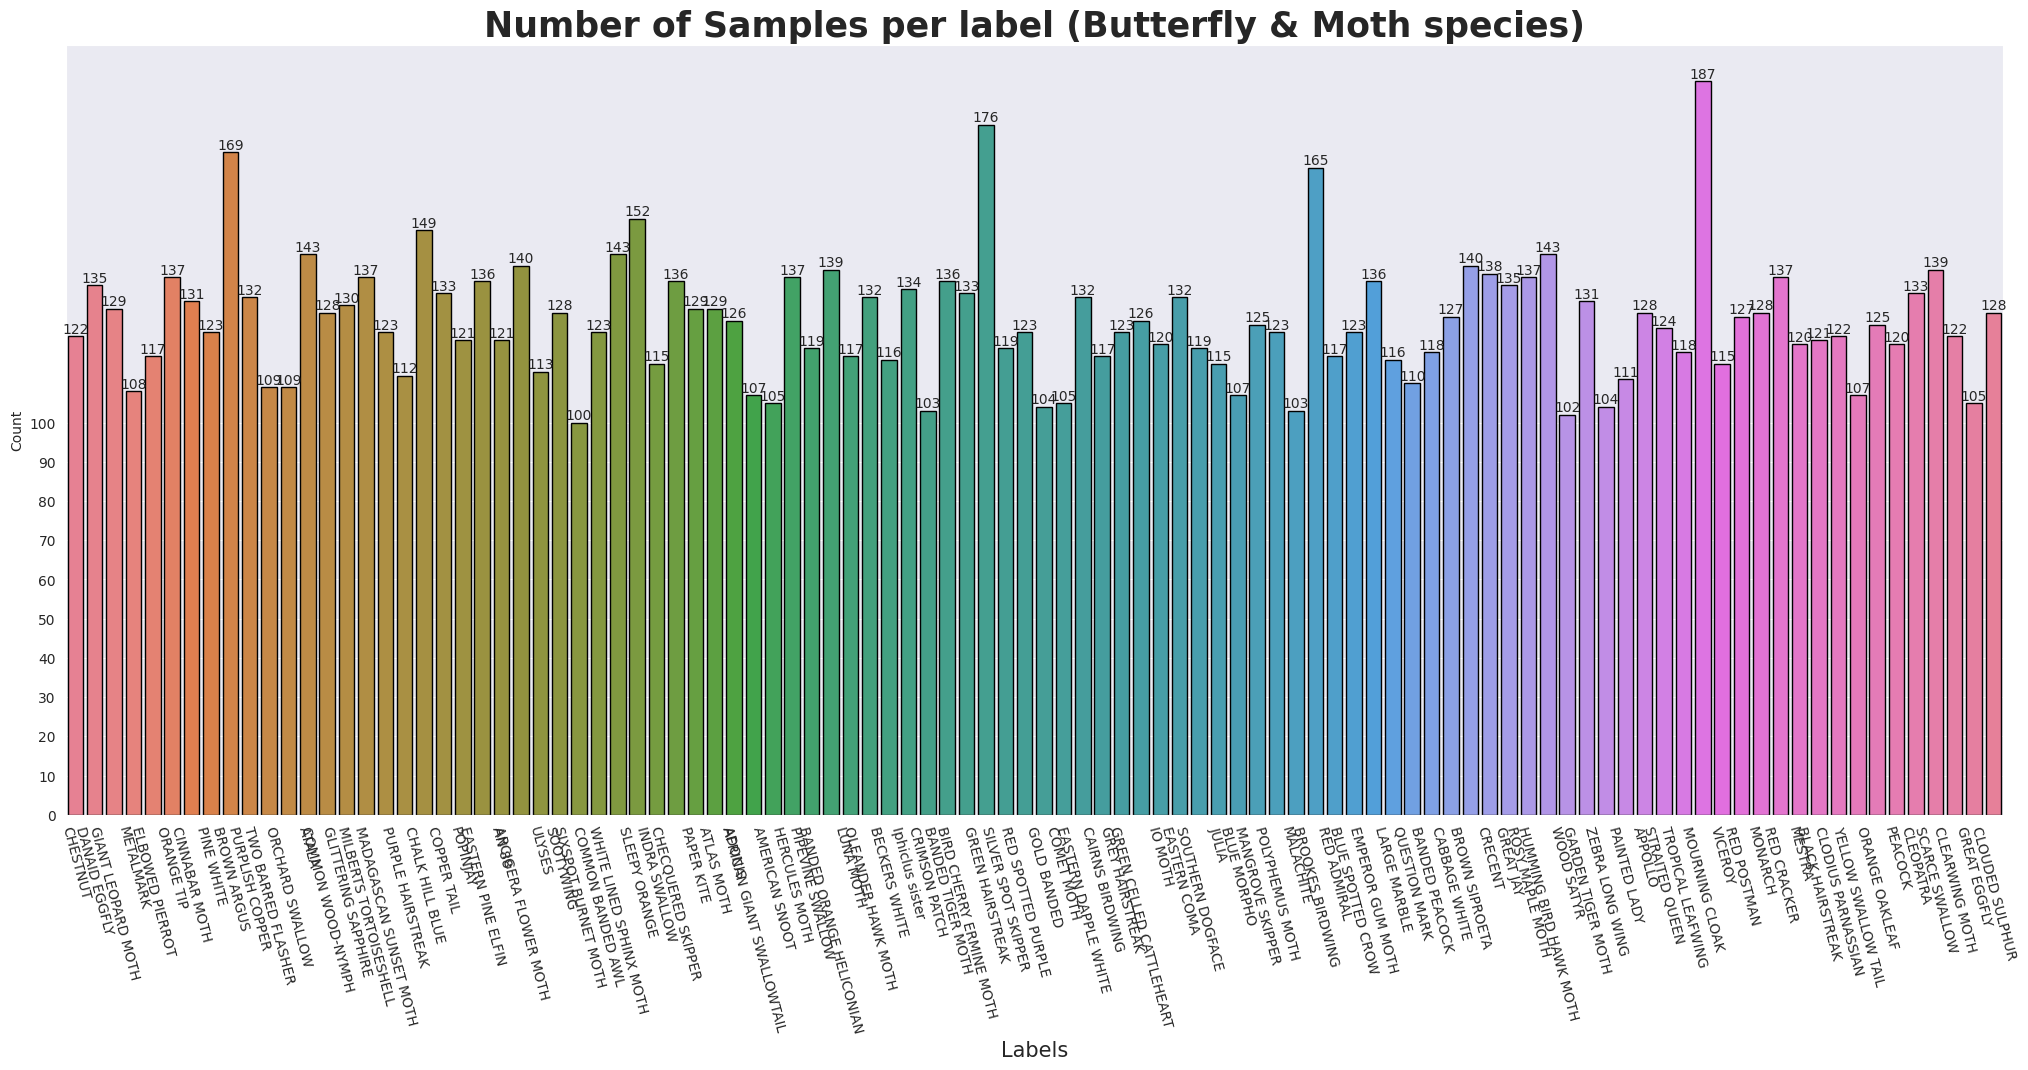

In [10]:
def num_of_classes(folder_dir, folder_name):
  classes = [class_name for class_name in os.listdir(train_dir)]
  print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 'green', attrs = ['bold']))
num_of_classes(train_dir, 'Train Directory')


classes = [class_name for class_name in os.listdir(train_dir)]
count = []

for class_name in classes:
  count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize = (25, 10))
ax = sns.barplot(x = classes, y = count, hue = classes, edgecolor = 'black')
plt.xticks(rotation = 285)

for i in ax.containers:
  ax.bar_label(i, )

plt.title('Number of Samples per label (Butterfly & Moth species)', fontsize = 25, fontweight = 'bold')
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Count')
plt.yticks(np.arange(0, 105, 10))
plt.show()

## Converting Data into DataFrame

In [11]:
def create_df(folder_path):
  all_images = []
  for class_name in classes:
    class_path = os.path.join(folder_path, class_name)
    all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
  df = pd.DataFrame(all_images, columns = ['file_path', 'label'])
  return df

train_dataset = create_df(train_dir)
test_dataset = create_df(test_dir)
val_dataset = create_df(val_dir)

print(colored(f"Number of samples in training dataset: {len(train_dataset)}", 'blue', attrs=['bold']))
print(colored(f"Number of samples in testing dataset: {len(test_dataset)}", 'red', attrs=['bold']))
print(colored(f"Number of samples in validating dataset: {len(val_dataset)}", 'green', attrs=['bold']))

Number of samples in training dataset: 12594
Number of samples in testing dataset: 500
Number of samples in validating dataset: 500


## Show Images per class Label

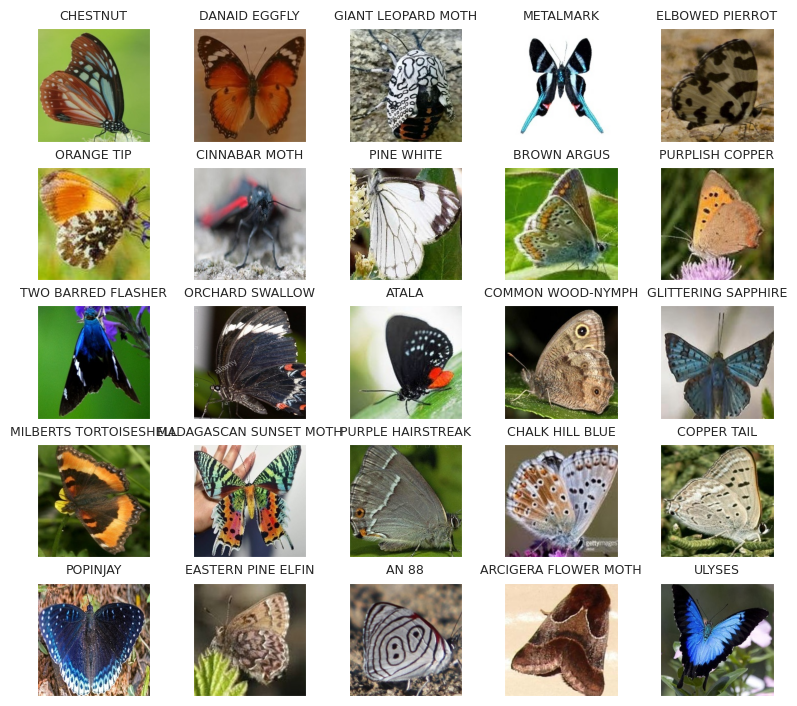

In [12]:
df_unique = train_dataset.copy().drop_duplicates(subset = ['label']).reset_index()

fig, axes = plt.subplots(5, 5, figsize = (8, 7),
                         subplot_kw = {'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.file_path[i]))
  ax.set_title(df_unique.label[i], fontsize = 9)
plt.tight_layout(pad = 0.5)
plt.show()

# Data Generator

### Train Generator

In [13]:
#Train Datagen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
  dataframe = train_dataset,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = True,
  seed = 42
)

Found 12594 validated image filenames belonging to 100 classes.


### Validation Generator

In [14]:
#Validation Generator
val_datagen = ImageDataGenerator(rescale=1./255,)

val_generator = val_datagen.flow_from_dataframe(
  dataframe = val_dataset,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = False,
  seed = 42
)

Found 500 validated image filenames belonging to 100 classes.


### Test Generator

In [15]:
test_datagen = ImageDataGenerator(rescale=1. / 255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_dataset,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    seed = 42,
    shuffle = False
)

Found 500 validated image filenames belonging to 100 classes.


# Model

## Creating Model

In [16]:
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
bm_output = base_model.output
x = GlobalAveragePooling2D()(bm_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(100, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,765,476 (98.29 MB)

 Trainable params: 25,720,036 (98.11 MB)

 Non-trainable params: 45,440 (177.50 KB)

## Callbacks

In [18]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

## Compile

In [19]:
model.compile(optimizer = Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

# Training

In [20]:
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 297s 584ms/step - accuracy: 0.1241 - loss: 3.9298 - val_accuracy: 0.3160 - val_loss: 3.5988 - learning_rate: 0.0010
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 244s 479ms/step - accuracy: 0.5506 - loss: 1.6089 - val_accuracy: 0.5560 - val_loss: 1.9019 - learning_rate: 0.0010
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 198s 498ms/step - accuracy: 0.6969 - loss: 1.0619 - val_accuracy: 0.7800 - val_loss: 0.7415 - learning_rate: 0.0010
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 186s 454ms/step - accuracy: 0.7795 - loss: 0.7671 - val_accuracy: 0.6620 - val_loss: 1.5031 - learning_rate: 0.0010
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 184s 461ms/step - accuracy: 0.8141 - loss: 0.6537 - val_accuracy: 0.7420 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 201s 459ms/step - accuracy: 0.8341 - loss: 0.5607 - val_accuracy: 0.8120 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 215s 490ms/step - accura

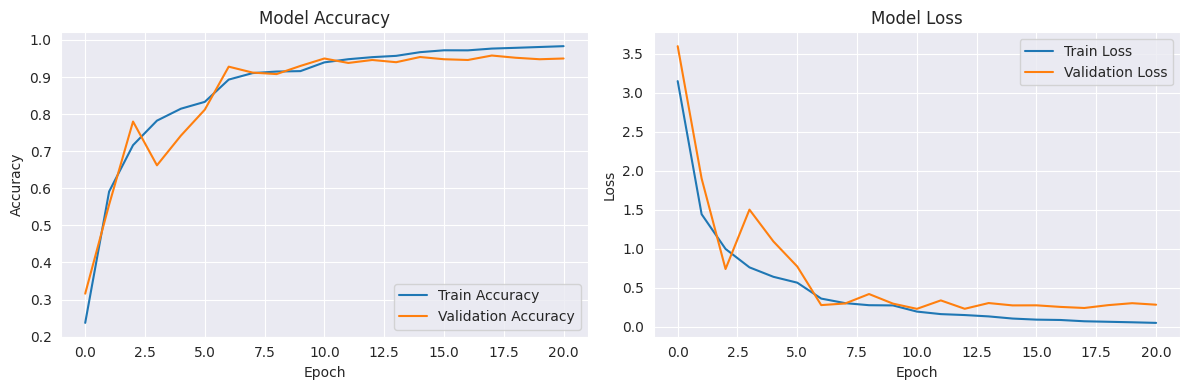

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step


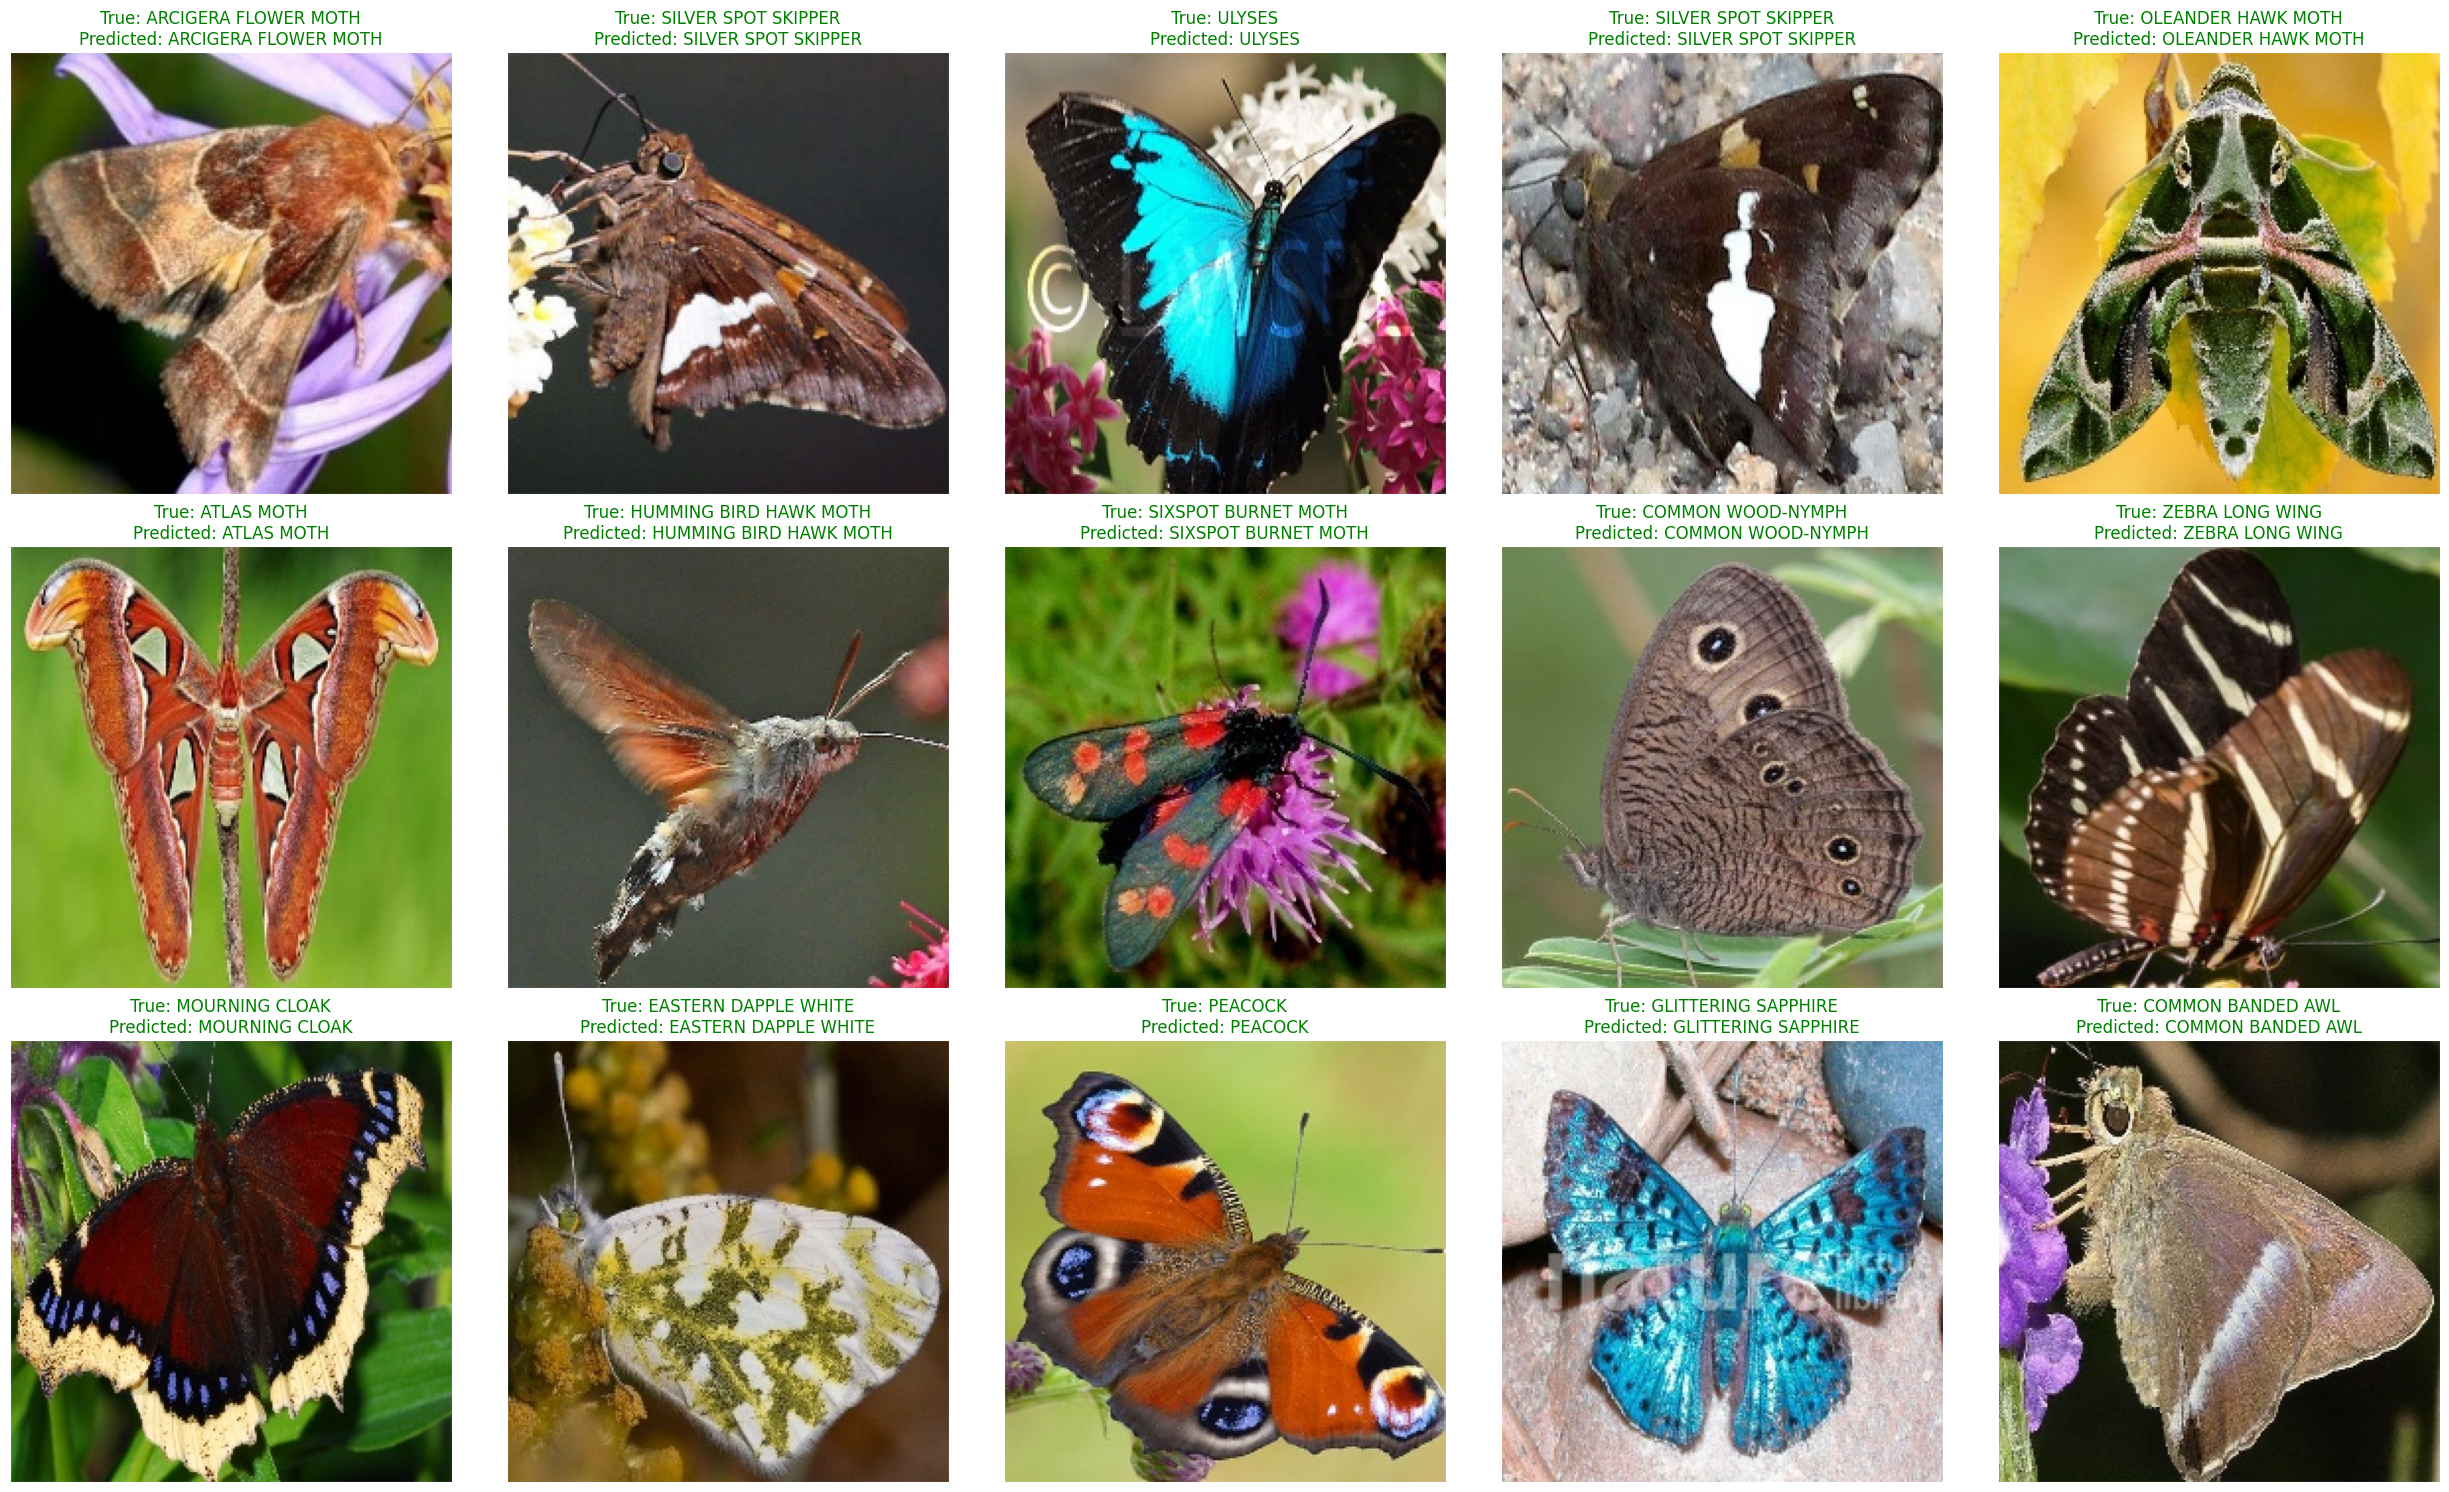

In [22]:
num_images = len(test_dataset)  # Assuming `test_dataset` is a pandas DataFrame with the test data

class_labels = list(train_generator.class_indices.keys())

# Getting all the true labels for the validation set
true_labels = test_generator.classes

# To get the predicted labels, we predict using the model
predictions = model.predict(test_generator, steps=len(test_generator))

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

random_index = np.random.randint(0, len(test_dataset) - 1, num_images)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test_dataset['file_path'].iloc[random_index[i]]
        true_label = test_dataset['label'].iloc[random_index[i]]

        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))

        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"

        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)

plt.tight_layout()
plt.show()

In [23]:
model.save('butterly_moth.h5')

In [24]:
class_label = list(train_generator.class_indices.keys())
class_labels

['ADONIS',
 'AFRICAN GIANT SWALLOWTAIL',
 'AMERICAN SNOOT',
 'AN 88',
 'APPOLLO',
 'ARCIGERA FLOWER MOTH',
 'ATALA',
 'ATLAS MOTH',
 'BANDED ORANGE HELICONIAN',
 'BANDED PEACOCK',
 'BANDED TIGER MOTH',
 'BECKERS WHITE',
 'BIRD CHERRY ERMINE MOTH',
 'BLACK HAIRSTREAK',
 'BLUE MORPHO',
 'BLUE SPOTTED CROW',
 'BROOKES BIRDWING',
 'BROWN ARGUS',
 'BROWN SIPROETA',
 'CABBAGE WHITE',
 'CAIRNS BIRDWING',
 'CHALK HILL BLUE',
 'CHECQUERED SKIPPER',
 'CHESTNUT',
 'CINNABAR MOTH',
 'CLEARWING MOTH',
 'CLEOPATRA',
 'CLODIUS PARNASSIAN',
 'CLOUDED SULPHUR',
 'COMET MOTH',
 'COMMON BANDED AWL',
 'COMMON WOOD-NYMPH',
 'COPPER TAIL',
 'CRECENT',
 'CRIMSON PATCH',
 'DANAID EGGFLY',
 'EASTERN COMA',
 'EASTERN DAPPLE WHITE',
 'EASTERN PINE ELFIN',
 'ELBOWED PIERROT',
 'EMPEROR GUM MOTH',
 'GARDEN TIGER MOTH',
 'GIANT LEOPARD MOTH',
 'GLITTERING SAPPHIRE',
 'GOLD BANDED',
 'GREAT EGGFLY',
 'GREAT JAY',
 'GREEN CELLED CATTLEHEART',
 'GREEN HAIRSTREAK',
 'GREY HAIRSTREAK',
 'HERCULES MOTH',
 'HUMMING BIRD H